In [1]:
import pandas as pd
import tifffile
import cv2
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from glob import glob
import warnings
import matplotlib.pyplot as plt
# warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

/home/ubuntu/Thesis/miniconda3/envs/bioMass/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SentinelDataset(Dataset):
    '''Sentinel 1 & 2 dataset.'''

    def __init__(self, dir_tiles, dir_target,
                 max_chips=None, transform=None, device='cpu'
                 ):
        '''
        Args:
            dir_tiles -- path to directory containing Sentinel data tiles
            dir_target -- path to directory containing target data (AGWB) tiles
            max_chips -- maximum number of chips to load, used for testing, None --> load all
            transform -- transforms to apply to each sample/batch
            device -- device to load data onto ('cpu', 'mps', 'cuda')
        '''
        
        self.tile_list = glob(dir_tiles+'*')
        self.tile_list = np.unique([x.split('/')[-1].split('_')[0] for x
                                    in self.tile_list if x.endswith('tif')])
        
        if max_chips:
            self.tile_list = self.tile_list[:max_chips]
            
        self.dir_tiles = dir_tiles
        self.dir_target = dir_target
        self.device = device
        self.transform = transform
        
        return
    
    def __len__(self):
        return len(self.tile_list)
    
    def __getitem__(self, idx):
        chipid = self.tile_list[idx]
        
        # Sentinel 1
        try:
            s1_tile = self._load_sentinel_tiles('S1', chipid)
            s1_tile_scaled = self._scale_channels(s1_tile)
        except:
            # print(f'Data load failure for S1: {chipid}')
            s1_tile_scaled = torch.full([4, 256, 256], torch.nan, dtype=torch.float32, requires_grad=False, device=self.device)
        # Sentinel 2
        try:
            s2_tile = self._load_sentinel_tiles('S2', chipid)
            s2_tile_scaled = self._scale_channels(s2_tile)
        except:
            # print(f'Data load failure for S2: {chipid} {month}')
            s2_tile_scaled = torch.full([11, 256, 256], torch.nan, dtype=torch.float32, requires_grad=False, device=self.device)

        # sentinel_tile = torch.cat([s2_tile_scaled, s1_tile_scaled], axis=0)

        if self.dir_target:
            target_tile = self._load_agbm_tile(chipid)
            target_tile = target_tile.clamp(target_tile.min(), target_tile.quantile(0.99)).unsqueeze(0)
        else:
            target_tile = torch.full([1, 256, 256], torch.nan, dtype=torch.float32, requires_grad=False, device=self.device)

        sample = {'image_s1': s1_tile_scaled, 'image_s2': s2_tile_scaled,
                  'label': target_tile} # 'image' and 'label' are used by torchgeo

        if self.transform:
            sample = self.transform(sample)

        return sample
    
    def _read_tif_to_tensor(self, tif_path):
        X = tifffile.imread(tif_path).astype(np.float32)
        X = torch.tensor(X,
                         dtype=torch.float32,
                         device=self.device,
                         requires_grad=False,
                         )
        return X

    def _load_sentinel_tiles(self, sentinel_type, chipid):
        file_name = f'{chipid}_{sentinel_type}.tif'
        tile_path = os.path.join(self.dir_tiles, file_name)
        return self._read_tif_to_tensor(tile_path)

    def _load_agbm_tile(self, chipid):
        target_path = os.path.join(self.dir_target,
                                   f'{chipid}_agbm.tif')
        return self._read_tif_to_tensor(target_path)
    
    def _scale_channels(self, x, top_quantile=0.99):
        
        assert len(x.shape)==3
        
        Ms = x.flatten(1, 2).quantile(0.99, dim=1, keepdim=True).unsqueeze(-1)
        ms = torch.amin(x, dim=(1, 2), keepdim=True)
        scaled = (x-ms)/(Ms-ms)
        scaled = scaled.clamp(0,1)
        
        return scaled

In [3]:
dir_tiles = '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/'
dir_target = '/home/ubuntu/Thesis/backup_data/bioMass_data/train_agbm/'

dataset = SentinelDataset(dir_tiles, dir_target, max_chips=500)

In [4]:
len(dataset)

500

In [9]:
test_tile = '/home/ubuntu/Thesis/backup_data/bioMass_data/train_PCA_warm/d961dfda_S2.tif'
x = torch.tensor(tifffile.imread(test_tile))

In [10]:
x.shape

torch.Size([11, 256, 256])

In [11]:
dataset._scale_channels(x)

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]

In [102]:
x = dataset[0]['label']
x.shape

torch.Size([1, 256, 256])

In [103]:
torch.amax(x, dim=(1, 2))

tensor([32.3800])

# Set up dataloader

In [104]:
from torch.utils.data import DataLoader, random_split

In [105]:
torch.manual_seed(0)

train_frac = 1
train_dataset, val_dataset = random_split(dataset, [train_frac, 1-train_frac])
print(f'N training samples: {len(train_dataset)}')

N training samples: 500


/home/ubuntu/Thesis/miniconda3/envs/bioMass/lib/python3.9/site-packages/torch/utils/data/dataset.py:342: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [76]:
batch_size = 5  # Note: training speed is sensitive to memory usage
                 # set this as high as you can without significantly slowing down training time 
num_workers = 2
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              pin_memory=True
                             )
val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=num_workers,
                            pin_memory=True
                           )

In [88]:
for sample in train_dataloader:
    sample
    break

In [78]:
sample['image_s2'].shape

torch.Size([5, 11, 256, 256])

## Does more n_workers improve loading speed?

It seems that it doesn't change much. Batch size does, tho.

In [85]:
import timeit
from functools import partial

def sample_one(dataloader):
    for sample in train_dataloader:
        sample
        break
    return

In [106]:
batch_size = 2

for n_workers in [1, 2, 4, 6, 8]:
    
    train_dataloader = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=True
                                 )
    
    mean_time = np.mean((timeit.Timer(partial(sample_one, dataset)).repeat(10, 1)))
    print(n_workers, mean_time)

1 0.7855238161981106
2 0.7799449745565653
4 0.7377596348524094
6 0.7175840318202973
8 0.6975218676030636


In [107]:
batch_size = 10

for n_workers in [1, 2, 4, 6, 8]:
    
    train_dataloader = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=True
                                 )
    
    mean_time = np.mean((timeit.Timer(partial(sample_one, dataset)).repeat(10, 1)))
    print(n_workers, mean_time)

1 2.2117911595851183
2 2.046762038394809
4 2.029267728701234
6 2.0108483348041775
8 1.9925696693360806


In [108]:
batch_size = 32

for n_workers in [1, 2, 4, 6, 8]:
    
    train_dataloader = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=True
                                 )
    
    mean_time = np.mean((timeit.Timer(partial(sample_one, dataset)).repeat(10, 1)))
    print(n_workers, mean_time)

1 5.612417998537421
2 5.669828491285443
4 5.668835337460041
6 5.731510932743549
8 5.774570039659738


# Should I use log for AGBM?

Data looks more well behaved for the log data. Think of a way to include this.

In [10]:
from joblib import Parallel, delayed

dir_target = '/home/ubuntu/Thesis/backup_data/bioMass_data/train_agbm/'
tile_list = glob(dir_target+'*')

data = Parallel(n_jobs=5)(delayed(tifffile.imread)(f) for f in tile_list)
all_data = np.array(data).flatten()

In [11]:
np.quantile(all_data, [0.99, 0.999, 0.9999])

array([304.70001221, 425.71696826, 583.80999756])

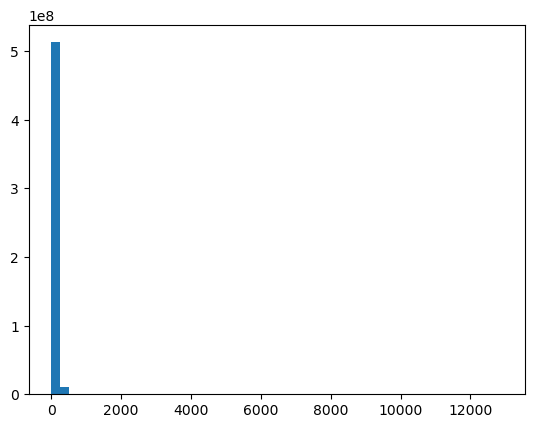

In [6]:
plt.hist(all_data, bins=50)
plt.show()

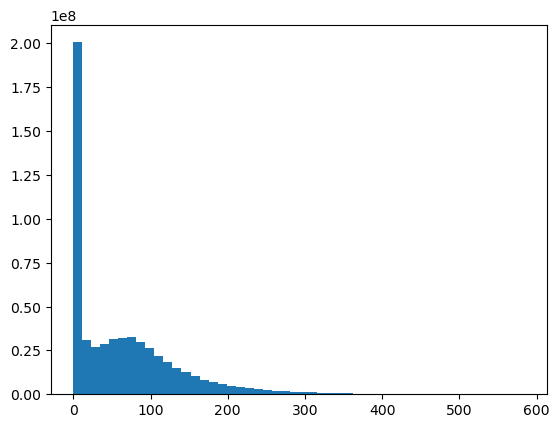

In [12]:
plt.hist(all_data, bins=50, range=[0, 583.80999756])
plt.show()

(array([1.44412237e+08, 3.17440000e+04, 1.61055000e+05, 4.65918000e+05,
        8.48366000e+05, 1.39799700e+06, 2.48264500e+06, 3.10828900e+06,
        4.32455500e+06, 5.16632700e+06, 5.78105400e+06, 6.22331200e+06,
        7.46936500e+06, 7.77477300e+06, 7.53631500e+06, 8.51619200e+06,
        9.24537800e+06, 1.10940040e+07, 1.36619870e+07, 1.69554340e+07,
        2.21989540e+07, 2.77069780e+07, 3.45969580e+07, 3.90312290e+07,
        3.85108110e+07, 3.33060630e+07, 2.62013360e+07, 1.88122250e+07,
        1.27988190e+07, 8.01623600e+06, 4.25300400e+06, 1.68724900e+06,
        4.10149000e+05, 5.95860000e+04, 1.80510000e+04, 9.24000000e+03,
        4.30700000e+03, 3.02900000e+03, 2.09400000e+03, 1.63500000e+03,
        1.08900000e+03, 7.79000000e+02, 5.06000000e+02, 3.00000000e+02,
        2.11000000e+02, 9.90000000e+01, 5.80000000e+01, 3.90000000e+01,
        9.00000000e+00, 1.00000000e+01]),
 array([0.        , 0.18930942, 0.37861884, 0.56792825, 0.75723767,
        0.94654715, 1.1358

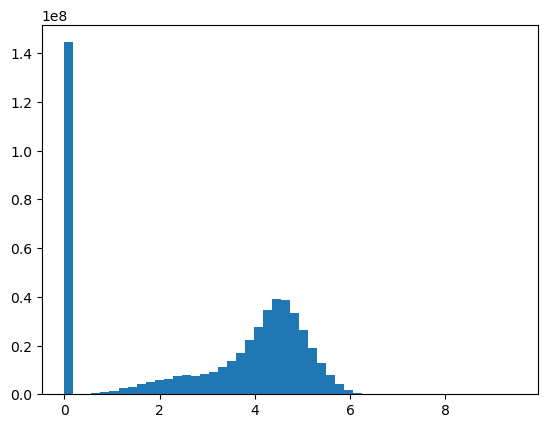

In [135]:
plt.hist(np.log(all_data+1), bins=50)